# **Импорт важных библиотек**

In [ ]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными

import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
from matplotlib.colors import ListedColormap # функция библиотеки Matplotlib, которая генерирует цветовую карту

from sklearn.datasets import make_moons, make_circles, make_classification # генерируемые наборы данных

from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и тестовую выборку
# но в исполнении scikit-learn

from sklearn.inspection import DecisionBoundaryDisplay # Класс библиотеки scikit-learn для визуализации границ решений

from sklearn.metrics import RocCurveDisplay

from sklearn.linear_model import LogisticRegression # Логистичекая регрессия от scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.preprocessing import PolynomialFeatures # Объект для генерации полиномиальных признаков от scikit-learn

from sklearn.metrics import confusion_matrix # матрица ошибок от scikit-learn


from sklearn.model_selection import StratifiedKFold # при кросс-валидации разбиваем данные пропорционально некой переменной
from sklearn.model_selection import cross_validate # кросс-валидация от scikit-learn


from sklearn.metrics import classification_report # функция которая рисует красивый отчет

from sklearn.metrics import accuracy_score as acc # Доля правильных ответов от scikit-learn

from sklearn.metrics import f1_score as f1 # f1-мера от scikit-learn

import sklearn.metrics

import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

In [ ]:
plt.style.use('dark_background')

функции для построения данных и функций принятия решения

In [ ]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, facecolor = 'None', alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
def plot_desicion_function(ax,ds,clf):
    X, y = ds
    h =  (X[:, 0].max() - X[:, 0].min())/50
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                          np.arange(y_min, y_max, h))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    cm = plt.cm.RdBu
    Z = Z.reshape(xx.shape)

    v=np.max(np.abs(Z))

    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8,vmin=-0.5*v, vmax=0.5*v)

функция выдающая коэффициенты модели `model`

In [ ]:
def get_coefs (model):
    B0=model.intercept_
    B=model.coef_
    return B0, B

функция выдающая коэффициенты для пайплайна `pipeline` с указанием полных имён признаков `input_features` которые в итоге получается

In [ ]:
def get_pipeline_coefs (pipeline, input_features ):
    B0=pipeline['model'].intercept_
    B=pipeline['model'].coef_
    features_names=pipeline['polynomial_features'].get_feature_names_out(input_features=input_features)
    return B0, B, list(features_names)

просим написать уравнение(-я) для пайплайна `pipeline`

In [ ]:
def write_equation_pipeline(model, input_features = ['X']):

    B0, B, features_names  = get_pipeline_coefs(model, input_features)

    for (b0,b_) in zip (B0,B):
        line='{:.2f}'.format(b0)
        sign=['+','-']
        for p,(fn,b) in enumerate(zip(features_names,b_)):
            if np.abs(b)>0:
                line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

        print('Решение')
        print(line)
        print('\n')

просим написать уравнение(-я) для модели `model`

In [ ]:
def write_equation(model, input_features = ['X']):

    B0, B  = get_coefs(model)

    for (b0,b_) in zip (B0,B):
        line='{:.2f}'.format(b0)
        sign=['+','-']
        for p,(fn,b) in enumerate(zip(input_features,b_)):
            if np.abs(b)>0:
                line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

        print('Решение')
        print(line)
        print('\n')

Оценка модели `model` на данных `X` и `y` по словарю метрик `scoring` при разделении кросс-валидации `cv_rule`

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_poly = pd.DataFrame(scores)
    display(DF_poly)
    print('\n')
    print(DF_poly.mean()[2:])

Визуализация весов в виде столбчатых диаграм

In [ ]:
def vis_weigths(weights,features_names = None):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса
    """
    numbers = np.arange(0,len(weights))                 # создаем массив от 0 до количество весов-1
    if features_names:
        tick_labels = np.hstack(['B0',features_names])
    else:
        tick_labels = ['B'+str(num) for num in numbers] # создаем "названия" весов


    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=1200,
                height=600,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

# Генерация данных

Попробуем создать несколько вариантов данных для классификации

In [ ]:
def make_binary_clf(N, method = 'line',
                    noises = 0.15,
                    random_state = 42):
    """Создание синтетического набора данных
    для бинарной классификации
    Входные переменные:
    ===========
    N: количество точек
    method: тип набора данных
    noises: коэффициент ~ сила шума
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """
    # фиксируем случайный seed
    if random_state: rng = np.random.RandomState(seed = random_state)

    if method == 'line' or method is None:
        # если выбран метод line (или никакой не задан)
        # то мы создаем набор данных с использованием функции make_classification
        # это будут линейно-разделимые данные
        X, y = make_classification(n_samples=N, # количество точек
                                   n_features=2, # количество признаков
                                   n_redundant=0, # количество бесполезных признаков
                                   n_informative=2,# количество информативных признаков
                                   n_clusters_per_class=1, # количество групп точек на класс
                                   class_sep=2, # количество классов
                                   random_state=random_state # фиксированный сид случайных чисел
                                   )
        X += np.random.randn(*X.shape) *noises # добавляем к признакам случайный шум

    elif method == 'moons':
        # если выбран метод moons
        # то мы создаем набор данных с использованием функции make_moons
        # это будут данные похожие на Инь-Ян
        X, y = make_moons(n_samples=N, # количество точек
                          noise=noises, # уровень шума
                          random_state=random_state # фиксированный сид случайных чисел
                          )

    elif method == 'circles':
        # если выбран метод circles
        # то мы создаем набор данных с использованием функции make_circles
        # это будут данные в виде концентрических окружностей
        X, y = make_circles(n_samples=N, # количество точек
                            noise=noises, # уровень шума
                            factor=0.5, # соотношение радиусов внуренней и внешней окружности
                            random_state=random_state # фиксированный сид случайных чисел
                            )


    return X,y

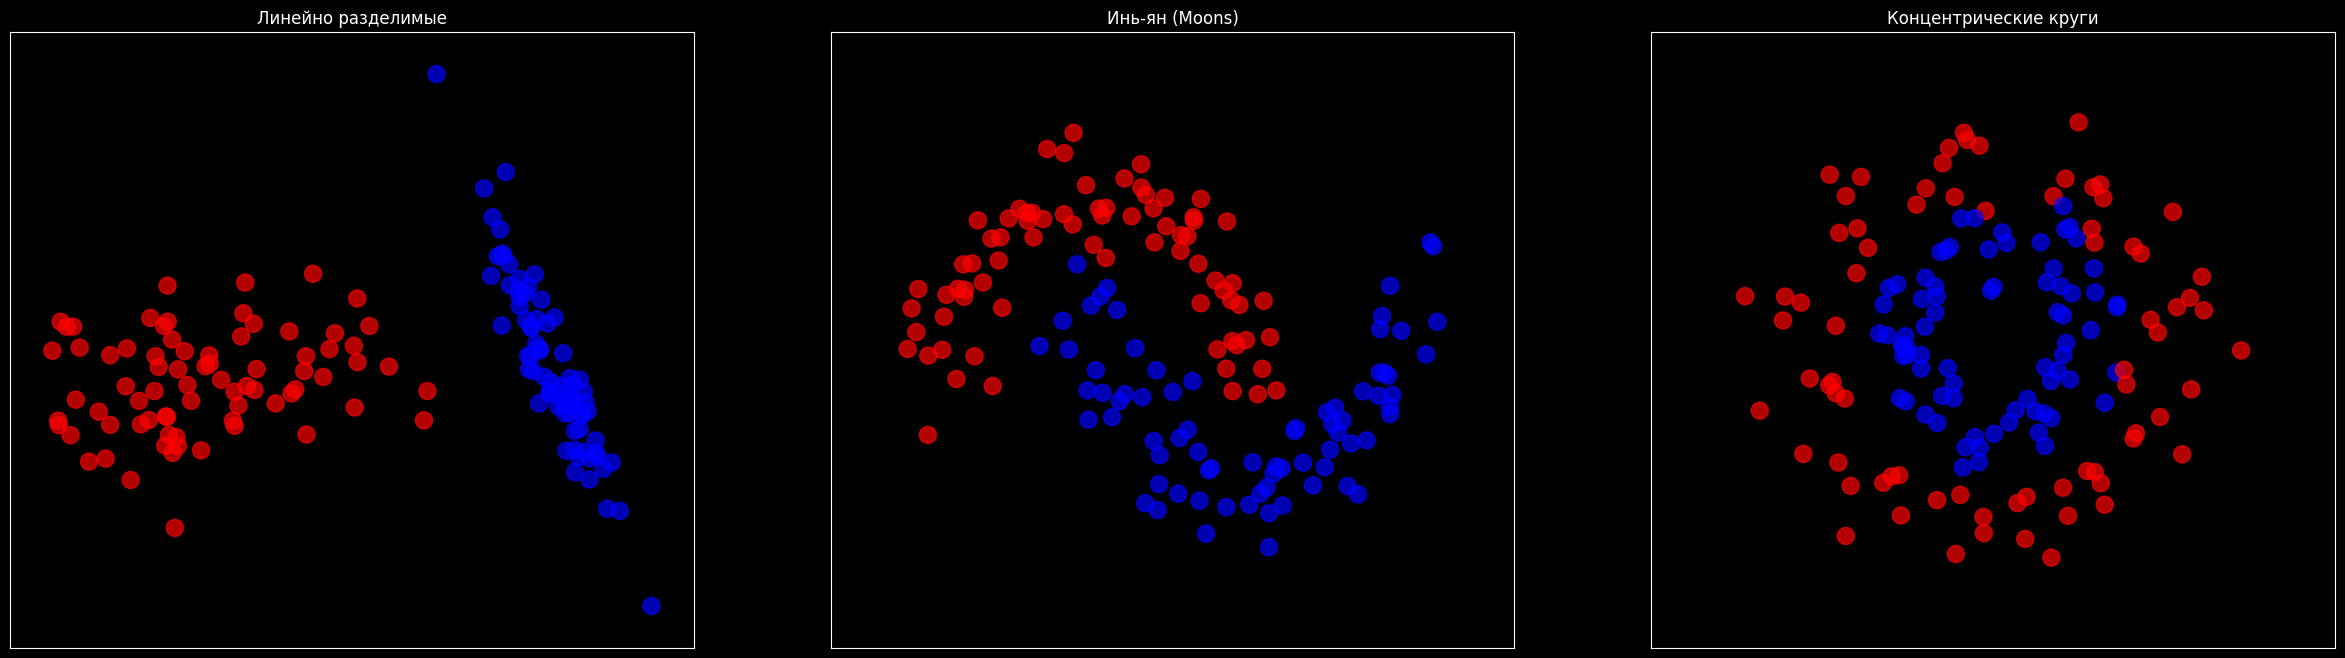

In [ ]:
#@title данные { run: "auto" }
N = 150 #@param {type:"slider", min:50, max:250, step:25}
noises = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}
# слайдерами можно изменять количество точек и уровень шума
# И - Интерактивностб

fig=plt.figure(figsize=(30,8))

linearly_separable = make_binary_clf(N,method = 'line')
Moons = make_binary_clf(N,method = 'moons')
Circles = make_binary_clf(N,method = 'circles')

ax = plt.subplot(1, 3, 1)
plot_data(ax,linearly_separable,
          'Линейно разделимые')
ax = plt.subplot(1, 3, 2)
plot_data(ax,Moons,
          'Инь-ян (Moons)')
ax = plt.subplot(1, 3, 3)
plot_data(ax, Circles,
          'Концентрические круги')



# Логистическая регрессия

Простая «линейная» модель

In [ ]:
#@title Набор Данных  { run: "auto" }
ds = Circles  #@param [ "linearly_separable" , "Moons", "Circles"]{type:"raw"}

LogReg = LogisticRegression(fit_intercept=True,)

X, y = ds

#Разбиваем данные на тренировочные и тестовые

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4,stratify = y)


### **Обучаем модель**

Шаг 1 - создаем экземпляр класса модели

Шаг 2 - обучаем методом `.fit`

Шаг 3 - считаем предсказание на тестовых данных `.predict`

In [ ]:
LogReg = LogisticRegression(fit_intercept=True,)

LogReg.fit(X_train, y_train)

y_predict=LogReg.predict(X_test)

## Напишем полученное решение

Не зря что-ли функцию писали

In [ ]:
write_equation(LogReg, input_features = ['x1','x2'])

Решение
-0.01-0.17*x1+0.30*x2




### Оцениваем модель по метрикам

На тестовой выборке

In [ ]:
print('Ошибка на тестовых данных')
print('ACC: %.4f' % acc(y_predict,y_test))
print('F1 : %.4f' %  f1(y_predict,y_test))

print (classification_report(y_test, y_predict, target_names=['red','blue']))

Ошибка на тестовых данных
ACC: 0.4500
F1 : 0.4407
              precision    recall  f1-score   support

         red       0.45      0.47      0.46        30
        blue       0.45      0.43      0.44        30

    accuracy                           0.45        60
   macro avg       0.45      0.45      0.45        60
weighted avg       0.45      0.45      0.45        60



### Рисуем графику

Используя функцию библиотеки scikit-learn

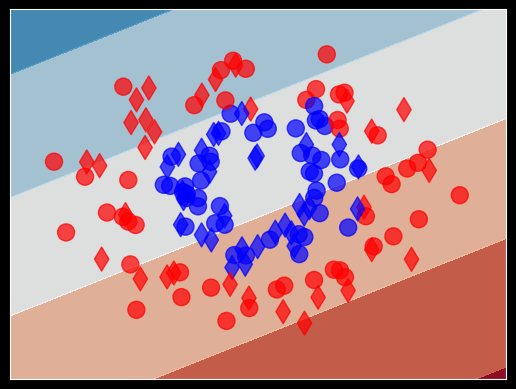

In [ ]:
# отрисовываем границу принятия решений с помощью Класса библиотеки scikit-learn
disp = DecisionBoundaryDisplay.from_estimator(
    LogReg, # Какой алгоритм используем
    X, # на каких данных проверяем
    response_method="predict_proba", # что визуализируе
    cmap= plt.cm.RdBu, # какую цветовую карту используем
    alpha=0.9, #прозрачность
)

plot_data(disp.ax_,(X_train,y_train))
plot_data(disp.ax_,(X_test,y_test), marker='d');

### Оценки с помощью кросс-валидации

In [ ]:
scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

cross_validation (X, y, LogReg, scoring, StratifiedKFold(n_splits=5))

Ошибка на кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.004042,0.009051,0.466667,0.428571,0.461538,0.400000
1,0.002746,0.004512,0.400000,0.437500,0.411765,0.466667
2,0.002253,0.004216,0.366667,0.457143,0.400000,0.533333
3,0.002211,0.004488,0.433333,0.451613,0.437500,0.466667
4,0.002084,0.005490,0.366667,0.387097,0.375000,0.400000




test_ACC          0.406667
test_F1           0.432385
test_Precision    0.417161
test_Recall       0.453333
dtype: float64


### Визуализация весов

In [ ]:
B0, B = get_coefs(LogReg)

for (b0,b_) in zip (B0,B):
    bs = np.hstack([b0,b_])
    vis_weigths(bs, ['x1','x2'])

### ROC AUC

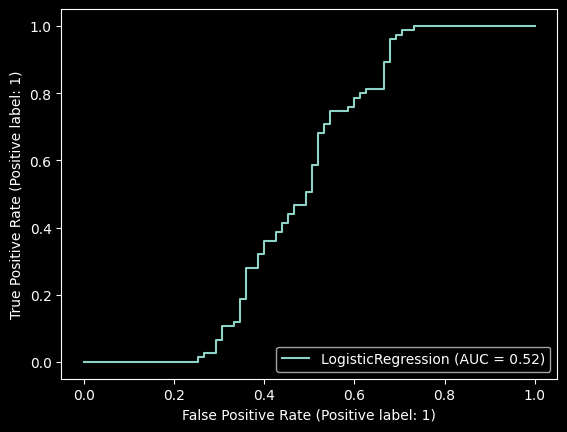

In [ ]:
RocCurveDisplay.from_estimator(LogReg,X, y,);

## Посмотрим на полиномы

Спрячем по традиции в функцию

Здесь мы берем данные (`X` и `y`), модель `model`, и степень полинома `degree`, которую ожидаем

In [ ]:
def polynomial_pipeline(X,y,model, degree, input_features = ['X']):
    PF = PolynomialFeatures(degree=degree,
                        include_bias=False,
                        interaction_only=False)

    pipeline = Pipeline([("polynomial_features", PF),
                    ("model", model)])

    pipeline.fit(X, y)

    write_equation_pipeline(pipeline, input_features )

    return pipeline

In [ ]:
#@title  Тестируем полиномиальные признаки  { run: "auto" }
#@markdown ### Степень полинома
degree = 5 #@param {type:"slider", min:1, max:10, step:1}
#@markdown ### Тип регуляризации
penalty= 'l1' #@param [ "l2" , "l1", "none"]{type:"string"}
#@markdown ### константа регуляризации
regularization = 1.2 #@param {type:"slider", min:0.1, max:5, step:0.1}




LogReg = LogisticRegression(fit_intercept=True,
                            penalty=penalty,solver='saga',
                            C=regularization,
                            max_iter=100000)


pipeline = polynomial_pipeline(X_train, y_train,
                    LogReg,  degree,
                    input_features = ['x1','x2'])

y_predict=pipeline.predict(X_test)

Решение
4.57+0.66*x2-8.21*x1^2-7.18*x2^2




### Оценка на метриках

In [ ]:
print('Ошибка на тестовых данных')
print('ACC: %.4f' % acc(y_predict,y_test))
print('F1 : %.4f' %  f1(y_predict,y_test))

print (classification_report(y_test, y_predict, target_names=['red','blue']))


Ошибка на тестовых данных
ACC: 0.9667
F1 : 0.9677
              precision    recall  f1-score   support

         red       1.00      0.93      0.97        30
        blue       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



### Графоний

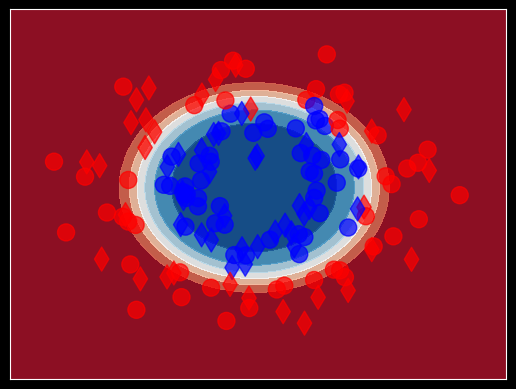

In [ ]:
# отрисовываем границу принятия решений с помощью Класса библиотеки scikit-learn
disp = DecisionBoundaryDisplay.from_estimator(
    pipeline, # Какой алгоритм используем
    X, # на каких данных проверяем
    response_method="predict_proba", # что визуализируе
    cmap= plt.cm.RdBu, # какую цветовую карту используем
    alpha=0.9, #прозрачность
)

plot_data(disp.ax_,(X_train,y_train))
plot_data(disp.ax_,(X_test,y_test), marker='d');

### Кросс-валидация

In [ ]:
scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

cross_validation (X, y, pipeline, scoring, StratifiedKFold(n_splits=5))

Ошибка на кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.093073,0.005549,0.966667,0.967742,0.937500,1.000000
1,0.024276,0.005290,0.966667,0.967742,0.937500,1.000000
2,0.020086,0.005948,0.966667,0.965517,1.000000,0.933333
3,0.018806,0.005821,0.933333,0.933333,0.933333,0.933333
4,0.015808,0.005116,1.000000,1.000000,1.000000,1.000000




test_ACC          0.966667
test_F1           0.966867
test_Precision    0.961667
test_Recall       0.973333
dtype: float64


### Веса

In [ ]:
B0, B, feature_names = get_pipeline_coefs(pipeline,
                                          input_features = ['x1','x2'])



for (b0,b_) in zip (B0,B):
    bs = np.hstack([b0,b_])
    vis_weigths(bs, feature_names)

### ROC AUC

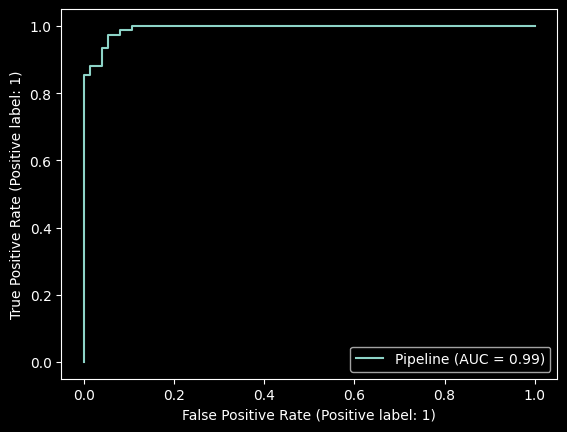

In [ ]:
RocCurveDisplay.from_estimator(pipeline,X, y,);

## **Важная заметка**

Функция cross_validate использует встроенные метрики

Проблема в том, что у него есть «жестко запрограммированные» классы по умолчанию - «0» и «1» для precision, recall, f1-score.

Поэтому убедитесь, что ваши классы имеют правильные метки.

В мультиклассовой задаче либо добавляете префиксы (рассмотрим позже)

Либо "вручную"

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

for n, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):

    pipeline.fit(X_train[train_index,:],y_train[train_index])

    y_cv_predict = pipeline.predict(X_train[test_index,:])
    print('Fold - %.i' % n)
    print('ACC: %.4f' % acc(y_cv_predict,y_train[test_index]))
    print('F1: %.4f' % f1(y_cv_predict,y_train[test_index]))
    print('\n')

Fold - 0
ACC: 0.8889
F1: 0.9000


Fold - 1
ACC: 0.9444
F1: 0.9474


Fold - 2
ACC: 1.0000
F1: 1.0000


Fold - 3
ACC: 1.0000
F1: 1.0000


Fold - 4
ACC: 1.0000
F1: 1.0000


